<center><h1 style="font-size:40px;">Regression</h1></center>

Welcome to the third lab in the Deep learning course! In this lab we will continue to take a look at four parts for MLP regression;
* Introduction for setup and train an MLP
* Model selection for classification
* Impact of overfitting in validation performance 
* Avoid overfitting for a regression problem

The lab includes different datasets, both synthetic and real for regression task. 
The first part of the lab uses two different synthetic regression problems. The **regr1()** synthetic dataset is a two-dimensional dataset with linear and non-linear relationships between the input features and the output value. It is a good benchmark dataset for regression models, as it is challenging and realistic. The **generate_piecewise_linear_data()** function generates a synthetic dataset with piecewise linear relationships between the input features and the output value with varying amount of noise for each piece. 

All **Tasks** include **TODO's** these are expected to be done before the deadline for this lab. The **Tasks** also include question(s), which should be answered and included in the report. Some sections do not contain any **TODO's** but are good to understand.

Good luck!

---

## Intro to regression


The regression task is to learn a function f that maps from a set of input features X to a continuous output value y. The input features X can be either real-valued or categorical. The output value y is a real-valued number.

$$
y = f(X) + \epsilon
$$

The regression model is trained on a set of training data points, where the input features and the output values are known. The model learns to identify the relationship between the input features and the output values, and then uses this relationship to predict the output value for new input features.



## Necessary Imports 

In [1]:
# select gpu by index in case of multiple gpus
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
import copy

## Let's use GPU if possible

In [3]:
# set device
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

## Dataset generator

In [4]:
class MLPData:
    """
    This class will manage all the dataset related functions for this lab.
    Please take the time do go through the code and try to understand how each point is generated
    """

    @staticmethod
    def regr1(N, v=0):
        """data(samples, features)

        :param N: param v:  (Default value = 0)
        :param v: Default value = 0)

        """
        data = np.empty(shape=(N, 2), dtype=np.float64)

        uni = lambda n: np.random.uniform(0, 1, n)
        norm = lambda n: np.random.normal(0, 1, n)
        noise = lambda n: np.random.normal(0, 1, (n,))
        data[:, 0] = norm(N)
        data[:, 1] = uni(N)

        tar = 10 * data[:, 0] + np.sin(20 * np.pi * data[:, 1])
        std_signal = np.std(tar)
        no = noise(N)
        tar = tar + v * std_signal * no
        return data, tar

    @staticmethod
    def generate_piecewise_linear_data(n_samples, n_segments, stocastic_noise=False):
        """
        Generates a piecewise linear dataset with n_segments segments.
        :param n_samples: Number of samples to generate
        :param n_segments: Number of segments to use
        :return: x, y

        """
        x = torch.rand(n_samples) * 10  # Generate random input values between 0 and 10
        y = torch.zeros(n_samples)

        segment_length = 10 / n_segments
        for i in range(n_segments):
            mask = (x >= i * segment_length) & (x < (i + 1) * segment_length)
            slope = torch.randn(1) * 2  # Random slope for each segment
            if stocastic_noise:
                noise = torch.randn(sum(mask)) * (0.5 + i * torch.randn(1))
            else:
                noise = torch.randn(sum(mask)) * (
                    0.5 + i * 0.2
                )  # Heteroscedastic noise
            y[mask] = slope * x[mask] + noise

        return x, y

Do not forget to instanciate an object of the above class for you to be able to generate dataset on the fly!

In [5]:
synthetic_datasets = MLPData()

Let's see how each dataset looks like! 

In [6]:
def data_distribution(imgs, shape=(2, 2)):
    """Plot scatter distribution for a list of images."""
    f, axs = plt.subplots(*shape, figsize=(10, 10))
    axs = axs.flatten()

    if isinstance(imgs, list):
        for idx, ((d, t), ax) in enumerate(zip(imgs, axs)):
            ax.scatter(d[:, 0], d[:, 1], c=t)
            ax.set_title(f"Plot number: {idx}")
    elif isinstance(imgs, dict):
        for (key, (d, t)), ax in zip(imgs.items(), axs):
            ax.scatter(d[:, 0], d[:, 1], c=t)
            ax.set_title(key)
    plt.show()

In [7]:
## Plotting synthetic datasets
# make sure you understand how the data is generated

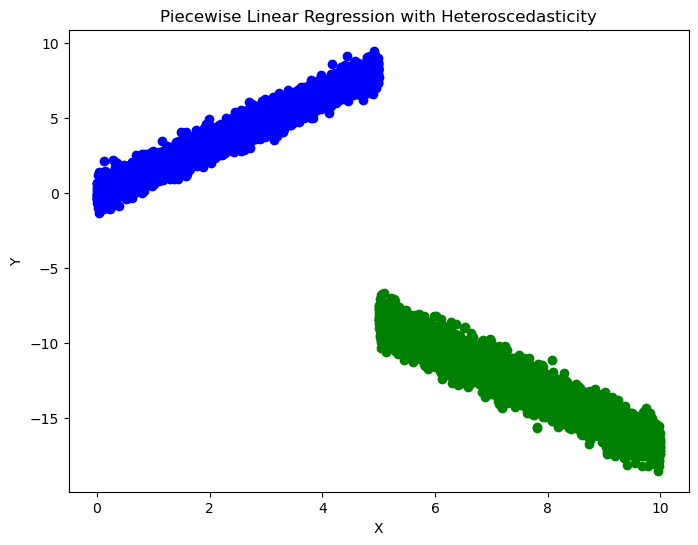

In [8]:
# Generate the synthetic dataset
n_samples = 10000
n_segments = 2
x, y = synthetic_datasets.generate_piecewise_linear_data(
    n_samples, n_segments, stocastic_noise=False
)

# Define colors for each segment
segment_colors = [
    "b",
    "g",
    "r",
    "c",
    "m",
] * (
    n_segments // 5 + 1
)  # Repeat the colors to have enough colors for each segment (up to 5 segments

# Plot the synthetic data with different colors for each segment
plt.figure(figsize=(8, 6))
for i in range(n_segments):
    mask = (x >= i * (10 / n_segments)) & (x < (i + 1) * (10 / n_segments))
    plt.scatter(x[mask], y[mask], label=f"Segment {i+1}", c=segment_colors[i])

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Piecewise Linear Regression with Heteroscedasticity")
plt.show()

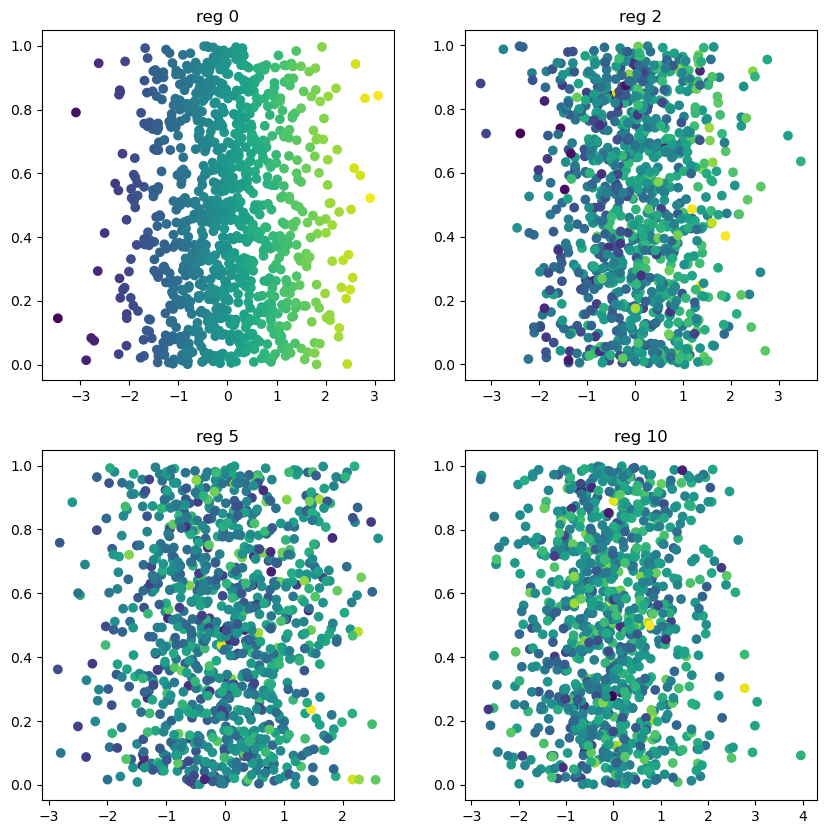

In [9]:
data_distribution(
    {
        "reg 0": MLPData.regr1(1000, v=0),
        "reg 2": MLPData.regr1(1000, v=2),
        "reg 5": MLPData.regr1(1000, v=5),
        "reg 10": MLPData.regr1(1000, v=10),
    },
    shape=(2, 2),
)

## Task 1

**Model definition**

In this lab exercise, you will design a Multi-Layer Perceptron (MLP) for regression. The goal is to create a simple neural network architecture to predict a continuous target variable based on input features. By completing this exercise, you will gain hands-on experience in configuring the architecture of an MLP for regression tasks.

    Task Description:

- Create an MLP architecture for regression.
- Define the input layer, hidden layers, and output layer.
- Configure the input layer to accept input data with dimensions specified as in_dimension.
- Design the hidden layers with num_hidden_layers layers and hidden_nodes neurons in each layer.
- Choose an appropriate activation function, specified as act, for the hidden layers. You can use common activation functions like ReLU (torch.nn.ReLU) for this purpose.
- Configure the output layer to have a linear activation function since this is a regression task.
- Define the output dimension to match your regression problem's requirements (specified as out_dimension).

In [ ]:
class NeuralNet(torch.nn.Module):
    def __init__(
        self,
        in_dimension=2,
        hidden_nodes=1,
        num_hidden_layers=1,
        act=torch.nn.ReLU(inplace=True),
        out_dimension=1,
    ):
        """
        in_dimension: number of input data/features
        hidden_nodes: number of neurons in the hidden layer(s)
        num_hidden_layers: number of hidden layers
        act: activation function
        out_dimension: number of output neurons e.g. number of classes
        """
        super(NeuralNet, self).__init__()
        # TODO: define the layers

    def forward(self, x):
        # TODO: define the forward pass
        raise NotImplementedError  # remove this line when you implement the function

## Process the data for training

We need to make tensor from the numpy data generated from ```MLPData``` class and use them to create a PyTorch dataset. For this exercise we will use ```TensorDataset```. To iterate over the dataset, we need a data loader. We will use the default ```DataLoader```. You can find the corresponding documentation [here](https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset) and [here](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader)

In [ ]:
# let's start with 100 points
x, y = synthetic_datasets.regr1(10000)
# simply convert each array to a Tensor
x = torch.Tensor(x)
y = torch.Tensor(y.squeeze())
# create the TensorDataset
syn2_Pytorch = TensorDataset(x, y)
# create the dataloader.
loader = DataLoader(syn2_Pytorch, batch_size=1024)

# Task 2

Finish the below function. The task at this point is to create a function that is able to train your ```model``` for ```epoch_number``` using ```optimizer```, ```loss``` and ```dataloader```. You can read about optimizer [here](https://pytorch.org/docs/stable/optim.html)

In [ ]:
def train_epoch(epoch, optimizer, loss, model, train_loader):
    """
    Trains the model for one epoch using the given training data.

    Args:
        epoch (int): The current epoch number.
        optimizer (torch.optim.Optimizer): The optimizer used for updating the model parameters.
        loss (torch.nn.Module): The loss function used for calculating the loss.
        model (torch.nn.Module): The neural network model to be trained.
        train_loader (torch.utils.data.DataLoader): The data loader providing training data.

    Returns:
        float: The average loss for the epoch.

    This function iterates through the provided `train_loader`, computes the forward pass,
    calculates the loss, performs backpropagation, and updates the model parameters using
    the given optimizer. It then returns the average loss for the entire epoch.

    Example:
        >>> optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
        >>> loss_fn = torch.nn.MSELoss()
        >>> train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        >>> for epoch in range(num_epochs):
        ...     epoch_loss = train_epoch(epoch, optimizer, loss_fn, model, train_loader)
        ...     print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")
    """

    total_loss = 0
    # TODO: set the model to training mode

    for batch_idx, (xi, yi) in enumerate(train_loader):
        # TODO: forward pass, loss calculation, backprop, update params
        loss = None

    # TODO: return loss for each epoch
    raise NotImplementedError  # remove this line when you implement the function

Now that we have a way to trian our model, we need to create an instance of the model and train it. We still need a way to evaluate our model. In this simple datasets, we can try to visualize the decision boundaries. 

We will create one ```helper function```: ```plot_decision_boundary```

In [ ]:
def plot_decision_boundary(dataset, y, model, steps=50):
    xmin, xmax = dataset[:, 0].min(), dataset[:, 0].max()
    ymin, ymax = dataset[:, 1].min(), dataset[:, 1].max()
    x_span = np.linspace(xmin, xmax, steps)
    y_span = np.linspace(ymin, ymax, steps)
    xx_pred, yy_pred = np.meshgrid(x_span, y_span)
    model_viz = np.array([xx_pred.flatten(), yy_pred.flatten()]).T

    # Make predictions across region of interest
    model.eval()
    labels_predicted = model(Variable(torch.Tensor(model_viz)).float())

    labels_predicted = labels_predicted.detach().numpy()

    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")
    ax.scatter(dataset[:, 0], dataset[:, 1], y)
    ax.scatter(
        xx_pred.flatten(),
        yy_pred.flatten(),
        labels_predicted,
        facecolor=(0, 0, 0, 0),
        s=20,
        edgecolor="#70b3f0",
    )
    ax.view_init(elev=28, azim=120)
    plt.show()
    model.train()
    return fig, ax

In [ ]:
def stats_reg(x, y, model):
    """
    Returns the MSE and CorrCoef for a given dataset and y
    """

    A = ["MSE", "CorrCoeff"]
    model.eval()
    preds = model(x)
    pcorr = np.corrcoef(y.flatten(), preds.detach().numpy().flatten())
    mse = torch.nn.MSELoss()(preds, y)

    B = [mse.item(), pcorr]

    print(f"\n {'#'*20} STATISTICS{'#'*20}\n")
    for r in zip(A, B):
        print(*r, sep="   ")
    return print(f"\n {'#'*50}")

## Task 3 

### Instantiation
Now the only thing missing to visualize you results is a trained network. **TODO:** Instantiate your model, loss and optimizer below. The choice of loss is critical for the training.  

In [ ]:
# TODO: instantiate model
my_model = None
# TODO: instantiate loss
critereon = None
# TODO: instantiate a suitable optimizer
optimizer = None

### Train the model

Now, our model, loss and optimizer are setup and we are ready to go Training

In [ ]:
num_epoch = 100
train_losses = list()
for epoch in range(1, num_epoch + 1):
    epoch_loss = train_epoch(epoch, optimizer, critereon, my_model, loader)
    train_losses.append(epoch_loss)

    if epoch % 10 == 0:
        print(f"Epoch {epoch + 1}/{num_epoch}: Loss = {epoch_loss}")

In [ ]:
plot_decision_boundary(x, y, my_model, steps=50)

In [ ]:
stats_reg(x, y, my_model)

## Visualize the train losses 

In [ ]:
ax = plt.figure().gca()
plt.plot(np.arange(len(train_losses)), train_losses)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.show()

## Model Selection 

A proper training procedure is divided into ```3 splits```: training, validation and test. Generally, for each epoch, training is done on training data, and then a validation is done on the validation data. During validation the model weights are not updated. Best performing model on the validaiton data is selected and saved for final evaluation on test data. 

## Task 4

**TODO:** Split the data to 3 parts, one for training, one for validation and one hold out set for testing. A good starting point can be 70%, 15% and 15% of the dataset respectively for each split

**HINT** you can either do this manually with indexing or use readily available tools e.g. in sklearn

In [ ]:
x, y = synthetic_datasets.regr1(10000)

train_dataset, train_loader = None, None
valid_dataset, valid_loader = None, None
test_dataset, test_loader = None, None

## Task 5
**TODO:** Complete the following functions. Run a proper training on each of the synthetic datasets you have created. Discuss the performance of model in report. What could be the reason behind the performance? Feel free to adapt the number of hidden nodes (and possibly the number of hidden layers and epochs)

In [ ]:
def validate_epoch(epoch, loss, model, val_loader):
    """
    Validates the model on the validation data for one epoch.

    Args:
        epoch (int): The current epoch number.
        loss (torch.nn.Module): The loss function used for calculating the validation loss.
        model (torch.nn.Module): The neural network model to be evaluated.
        val_loader (torch.utils.data.DataLoader): The data loader providing validation data.

    Returns:
        float: The average validation loss for the epoch.

    This function switches the provided model to evaluation mode, iterates through the
    validation data provided by `val_loader`, computes the forward pass, and calculates
    the validation loss. It then returns the average validation loss for the entire epoch.

    Example:
        >>> loss_fn = torch.nn.MSELoss()
        >>> val_loader = DataLoader(val_dataset, batch_size=32)
        >>> for epoch in range(num_epochs):
        ...     epoch_loss = validate_epoch(epoch, loss_fn, model, val_loader)
        ...     print(f"Epoch {epoch+1}, Validation Loss: {epoch_loss:.4f}")
    """

    total_loss = 0
    # TODO: switch the model to evaluation mode

    with torch.no_grad():
        for batch_idx, (xi, yi) in enumerate(val_loader):
            # TODO: forward pass, loss calculation
            loss = None

    # TODO: return loss for each epoch
    raise NotImplementedError  # remove this line when you implement the function

In [ ]:
def a_proper_training(num_epoch, model, optimizer, loss, train_loader, val_loader):
    """
    Performs a complete training and validation process for the given model.

    Args:
        num_epoch (int): The number of training epochs.
        model (torch.nn.Module): The neural network model to be trained.
        optimizer (torch.optim.Optimizer): The optimizer used for updating the model parameters.
        loss (torch.nn.Module): The loss function used for calculating the loss.
        train_loader (torch.utils.data.DataLoader): The data loader providing training data.
        val_loader (torch.utils.data.DataLoader): The data loader providing validation data.

    Returns:
        tuple: A tuple containing the best trained model, a list of training losses for each epoch,
        and a list of validation losses for each epoch.

    This function trains the provided model for the specified number of epochs, monitoring both
    training and validation losses. It also saves the best model based on the lowest validation
    loss achieved during training.

    Example:
        >>> num_epochs = 10
        >>> optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
        >>> loss_fn = torch.nn.MSELoss()
        >>> train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        >>> val_loader = DataLoader(val_dataset, batch_size=32)
        >>> best_model, train_losses, val_losses = a_proper_training(num_epochs, model, optimizer, loss_fn, train_loader, val_loader)
        >>> # After training, you can use the best_model for inference.
    """
    best_val_loss = None
    train_losses = list()
    val_losses = list()
    for epoch in range(num_epoch):
        train_loss = train_epoch(epoch, optimizer, loss, model, train_loader)
        val_loss = validate_epoch(epoch, loss, model, val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        # TODO: if val_loss is lower than best_val_loss, store the model to best_model
        # first epoch is an exception

    # TODO: return best model, and lists of training and validation losses for each epoch for plotting
    return (None, None, None)

In [ ]:
# TODO: instantiate model
my_model = None
# TODO: instantiate loss
critereon = None
# TODO: instantiate a suitable optimizer
optimizer = None

In [ ]:
best_model, train_losses, val_losses = a_proper_training(
    1000, my_model, optimizer, critereon, train_loader, valid_loader
)

In [ ]:
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.title("MSE Loss")
plt.legend()

## Task 6 

Add dropout to the model, and rerun the previous experiment, does it have any effect and why?

In [ ]:
class NeuralNet(torch.nn.Module):
    def __init__(
        self,
        in_dimension=2,
        hidden_nodes=1,
        num_hidden_layers=1,
        act=torch.nn.ReLU(inplace=True),
        out_dimension=1,
    ):
        """
        in_dimension: number of input data/features
        hidden_nodes: number of neurons in the hidden layer(s)
        num_hidden_layers: number of hidden layers
        act: activation function
        out_dimension: number of output neurons e.g. number of classes
        """
        super(NeuralNet, self).__init__()
        # TODO: define the layers

    def forward(self, x):
        # TODO: define the forward pass
        raise NotImplementedError  # remove this line when you implement the function

    def predict(self, x):
        return torch.argmax(self.forward(x), dim=-1)

## Task 7


**TODO!** Rerun the experiment with the second synthetic dataset, with splitting, and proper training. Feel free to play with the parameters of the models

In [ ]:
# Generate the synthetic dataset
n_samples = 10000
n_segments = 5
X, y = synthetic_datasets.generate_piecewise_linear_data(
    n_samples, n_segments, stocastic_noise=True
)

train_dataset, train_loader = None, None
valid_dataset, valid_loader = None, None
test_dataset, test_loader = None, None

In [ ]:
# TODO: instantiate model
my_model = NeuralNet(in_dimension=1, hidden_nodes=14, num_hidden_layers=1)
# TODO: instantiate loss
critereon = nn.MSELoss()
# TODO: instantiate a suitable optimizer
optimizer = Adam(my_model.parameters(), lr=0.001)

In [ ]:
best_model, train_losses, val_losses = a_proper_training(
    10000, my_model, optimizer, critereon, train_loader, valid_loader
)

In [ ]:
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.title("MSE Loss")
plt.legend()

In [ ]:
def stats_reg(dataloader, model):
    """
    Returns the MSE and CorrCoef for a given PyTorch dataset and model
    """

    A = ["MSE", "CorrCoeff"]
    model.eval()

    for x, y in dataloader:
        preds = model(x)
        pcorr = np.corrcoef(y.flatten(), preds.detach().numpy().flatten())
        mse = nn.MSELoss()(preds, y)

    B = [mse.item(), pcorr[0, 1]]

    print(f"\n {'#'*20} STATISTICS{'#'*20}\n")
    for r in zip(A, B):
        print(*r, sep="   ")
    return print(f"\n {'#'*50}")

In [ ]:
stats_reg(test_loader, my_model)

<center><h1 style="font-size:40px;">Real dataset</h1></center>

## Task 9

In the following example, we will import the diabetes dataset. This dataset contains data from diabetic patients and contains certain features such as their bmi, age , blood pressure and glucose levels which are useful in predicting the diabetes disease progression in patients.

Here are the key details of the sklearn diabetes dataset:

- Target Variable: The target variable is a quantitative measure of disease progression, which represents the one-year change in a patient's disease progression. It is a continuous variable, not a binary classification of diabetes.
- Features (Predictors):
    The dataset contains ten baseline variables (predictors) that are used to predict the disease progression:

        - Age
        - Sex
        - BMI (Body Mass Index)
        - Average Blood Pressure
        - S1: Total serum cholesterol
        - S2: Low-density lipoproteins (LDL cholesterol)
        - S3: High-density lipoproteins (HDL cholesterol)
        - S4: Total cholesterol / HDL cholesterol ratio
        - S5: Log of serum triglycerides level
        - S6: Blood sugar level

In [ ]:
from sklearn import datasets
import seaborn as sns
import pandas as pd

In [ ]:
diabetes = datasets.load_diabetes(scaled=True, as_frame=True, return_X_y=True)
X, y = diabetes[0], diabetes[1]
X = X.astype(np.float32)
y = y.astype(np.float32)

In [ ]:
cols = list(X.columns) + ["Target"]
diabetes_df = pd.DataFrame(np.hstack([X, np.atleast_2d(y).T]), columns=cols)
plt.figure(figsize=(12, 10))
sns.heatmap(diabetes_df.corr(), annot=True)

**TODO:**  run the experiments for the diabetes dataset, do you get similar performance? why? Do you suffer from overfitting/underfitting?

## Task 10

**TODO** try applying l1 and l2 regularization, does it help with the performance? Why?

**HINT** in pytorch l2 can be applied by adding weight decay to optimizer, and for adding L1, you can choose HuberLoss instead of MSE. Or feel free to apply them manually